c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Epoch [500/500]  Loss: 0.001189

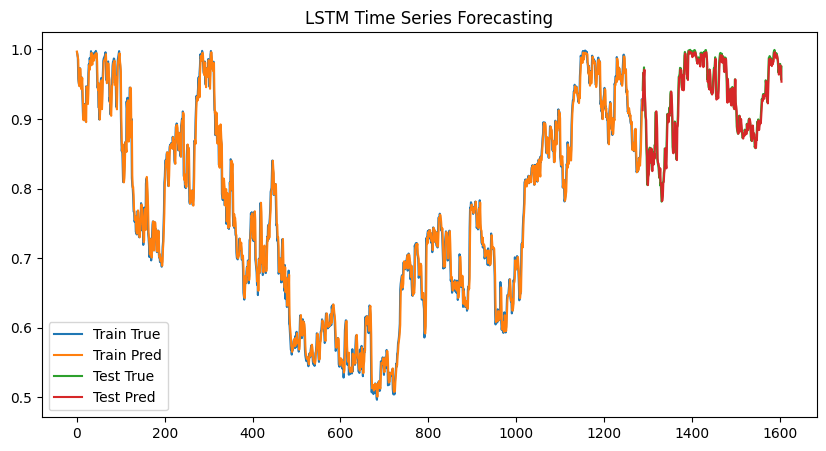

  Method      RMSE       MAE      MAPE      MASE
0   LSTM  0.013252  0.009536  0.010431  1.014231


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('./data/BTC_factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
start_time = '2021-01-01 00:00:00'
df = df.sort_values('datetime')
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()
df = df[start_time:]
values = df["profit_relative"].values.astype(float)
values =values.reshape(-1,1)

scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)
train_size = int(len(values_scaled) * 0.8)
train_data = values_scaled[:train_size]
test_data = values_scaled[train_size:]

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 7
hidden_size = 64
num_layers = 1
epochs = 500
lr = 0.01

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# 转为 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=hidden_size, num_layers=num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]                # 取最后一个时间步的输出
        out = self.fc(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"\rEpoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}", end="")
        
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# 反归一化到原始数值
train_pred = scaler.inverse_transform(train_pred.numpy())
y_train_true = scaler.inverse_transform(y_train.numpy())

test_pred = scaler.inverse_transform(test_pred.numpy())
y_test_true = scaler.inverse_transform(y_test.numpy())
plt.figure(figsize=(10,5))
plt.plot(range(len(y_train_true)), y_train_true, label="Train True")
plt.plot(range(len(train_pred)), train_pred, label="Train Pred")

plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), y_test_true, label="Test True")
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_test_true)), test_pred, label="Test Pred")
plt.legend()
plt.title("LSTM Time Series Forecasting")
plt.show()

MSE = np.mean((test_pred-y_test_true)**2)
MAE = np.mean(np.abs(test_pred-y_test_true))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test_pred-y_test_true)/y_test_true))
MASE = np.mean(np.abs(y_test_true-test_pred))/np.mean(np.abs(np.array(y_test_true[1:])-np.array(y_test_true[:-1])))
result= [{'Method':' LSTM','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
print(result_frame)


In [15]:

MSE = np.mean((test_pred-y_test_true)**2)
MAE = np.mean(np.abs(test_pred-y_test_true))
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test_pred-y_test_true)/y_test_true))
MASE = np.mean(np.abs(y_test_true-test_pred))/np.mean(np.abs(np.array(y_test_true[1:])-np.array(y_test_true[:-1])))
result= [{'Method':' LSTM','RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'MASE':MASE}]
result_frame = pd.DataFrame(result)
result_frame

,Method,RMSE,MAE,MAPE,MASE
0,LSTM,0.013252,0.009536,0.010431,1.014231


c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


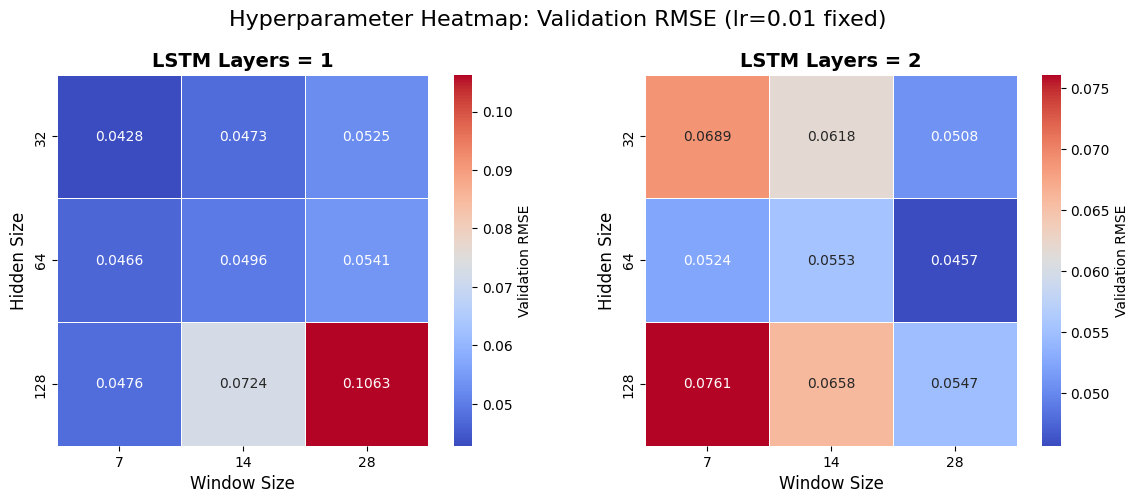

🔍 全局最优超参数（验证集）：
  num_layers: 1
  window_size: 7
  hidden_size: 32
  val_RMSE: 0.042821


In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

fixed_lr = 0.01
# ----------------------------
# 1. 数据加载与划分（同前）
# ----------------------------
df = pd.read_csv('./data/BTC_factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values(df.columns[0])
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()
start_time = '2021-01-01 00:00:00'
df = df[start_time:]

values = df["profit_relative"].values.astype(float).reshape(-1, 1)

# ======================================
#   先划分训练集与测试集（未归一化）
# ======================================
total_len = len(values)
train_test_split = int(total_len * 0.8)

train_full_raw = values[:train_test_split]
test_raw = values[train_test_split:]

# ======================================
#   在训练集上拟合 scaler，避免未来泄露
# ======================================
scaler = MinMaxScaler()
train_full_scaled = scaler.fit_transform(train_full_raw)
test_scaled = scaler.transform(test_raw)

# ======================================
#   再划分训练集与验证集
# ======================================
val_size = int(len(train_full_scaled) * 0.2)
train_data = train_full_scaled[:-val_size]
val_data = train_full_scaled[-val_size:]
test_data = test_scaled


# ----------------------------
# 2. 模型 & 评估函数（lr 固定 = 0.001）
# ----------------------------
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=500):
    X_train, y_train = create_dataset(train_data, ws)
    X_val, y_val = create_dataset(val_data, ws)
    if len(X_train) == 0 or len(X_val) == 0:
        return np.nan  # 用 NaN 标记无效组合

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    model = LSTMModel(1, hs, nl)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        loss = crit(model(X_train_t), y_train_t)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        rmse = np.sqrt(crit(model(X_val_t), y_val_t).item())
    return rmse

# ----------------------------
# 3. 搜索：固定 lr=0.001，遍历 (ws, hs, nl)
# ----------------------------
window_sizes = [7, 14, 28]
hidden_sizes = [32, 64, 128]
num_layers_list = [1, 2]

# 为两个层数分别构建 DataFrame（用于 heatmap）
heatmaps = {}

for nl in num_layers_list:
    matrix = np.full((len(hidden_sizes), len(window_sizes)), np.nan)
    for i, hs in enumerate(hidden_sizes):
        for j, ws in enumerate(window_sizes):
            rmse = evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=50)
            matrix[i, j] = rmse
    # 构建 DataFrame
    df_heat = pd.DataFrame(
        matrix,
        index=hidden_sizes,      # y 轴
        columns=window_sizes     # x 轴
    )
    heatmaps[nl] = df_heat

# ----------------------------
# 4. 绘制两个热力图（并排）
# ----------------------------
plt.figure(figsize=(12, 5))

for idx, nl in enumerate([1, 2]):
    plt.subplot(1, 2, idx + 1)
    df_heat = heatmaps[nl]
    
    # 热力图：annot=True 显示数值，fmt=".4f" 保留4位小数
    sns.heatmap(
        df_heat,
        annot=True,
        fmt=".4f",
        cmap="coolwarm",        # 蓝→低 RMSE，红→高 RMSE
        cbar_kws={'label': 'Validation RMSE'},
        linewidths=0.5,
        square=True
    )
    
    plt.title(f'LSTM Layers = {nl}', fontsize=14, fontweight='bold')
    plt.xlabel('Window Size', fontsize=12)
    plt.ylabel('Hidden Size', fontsize=12)

plt.suptitle('Hyperparameter Heatmap: Validation RMSE (lr=0.01 fixed)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 为 suptitle 留空间
plt.show()

# ----------------------------
# 5. 找出全局最优（可选）
# ----------------------------
all_results = []
for nl, df_heat in heatmaps.items():
    df_melt = df_heat.reset_index().melt(
        id_vars='index',
        var_name='window_size',
        value_name='val_rmse'
    )
    df_melt.rename(columns={'index': 'hidden_size'}, inplace=True)
    df_melt['num_layers'] = nl
    all_results.append(df_melt)

full_df = pd.concat(all_results, ignore_index=True)
best_row = full_df.loc[full_df['val_rmse'].idxmin()]
print("🔍 全局最优超参数（验证集）：")
print(f"  num_layers: {int(best_row['num_layers'])}")
print(f"  window_size: {int(best_row['window_size'])}")
print(f"  hidden_size: {int(best_row['hidden_size'])}")
print(f"  val_RMSE: {best_row['val_rmse']:.6f}")

c:\Users\cloudcine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


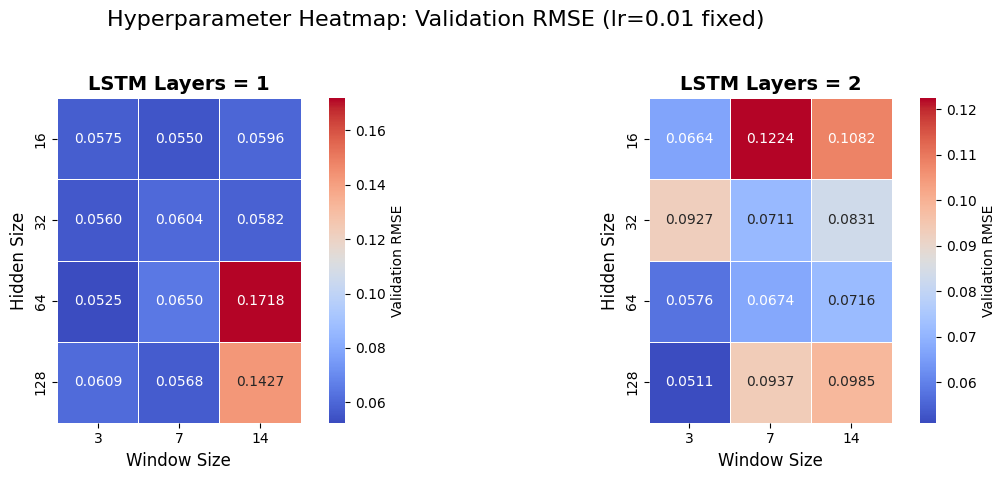

🔍 全局最优超参数（验证集）：
  num_layers: 2
  window_size: 3
  hidden_size: 128
  val_RMSE: 0.051057


In [17]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

fixed_lr = 0.01
epoch = 50

window_sizes = [3, 7, 14]
hidden_sizes = [16, 32, 64, 128]
num_layers_list = [1, 2]

# ----------------------------
# 1. 数据加载与划分（同前）
# ----------------------------
df = pd.read_csv('./data/BTC_factors/addresses/BTC_1h_profit_relative.csv')
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values(df.columns[0])
df.set_index(df.columns[0], inplace=True)
df = df.resample('D').mean()
start_time = '2023-01-01 00:00:00'
df = df[start_time:]

values = df["profit_relative"].values.astype(float).reshape(-1, 1)

# ======================================
#   先划分训练集与测试集（未归一化）
# ======================================
total_len = len(values)
train_test_split = int(total_len * 0.8)

train_full_raw = values[:train_test_split]
test_raw = values[train_test_split:]

# ======================================
#   在训练集上拟合 scaler，避免未来泄露
# ======================================
scaler = MinMaxScaler()
train_full_scaled = scaler.fit_transform(train_full_raw)
test_scaled = scaler.transform(test_raw)

# ======================================
#   再划分训练集与验证集
# ======================================
val_size = int(len(train_full_scaled) * 0.2)
train_data = train_full_scaled[:-val_size]
val_data = train_full_scaled[-val_size:]
test_data = test_scaled


# ----------------------------
# 2. 模型 & 评估函数（lr 固定 = 0.001）
# ----------------------------
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=epoch):
    X_train, y_train = create_dataset(train_data, ws)
    X_val, y_val = create_dataset(val_data, ws)
    if len(X_train) == 0 or len(X_val) == 0:
        return np.nan  # 用 NaN 标记无效组合

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    model = LSTMModel(1, hs, nl)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        loss = crit(model(X_train_t), y_train_t)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        rmse = np.sqrt(crit(model(X_val_t), y_val_t).item())
    return rmse

# ----------------------------
# 3. 搜索：固定 lr=0.001，遍历 (ws, hs, nl)
# ----------------------------

# 为两个层数分别构建 DataFrame（用于 heatmap）
heatmaps = {}

for nl in num_layers_list:
    matrix = np.full((len(hidden_sizes), len(window_sizes)), np.nan)
    for i, hs in enumerate(hidden_sizes):
        for j, ws in enumerate(window_sizes):
            rmse = evaluate_params(ws, hs, nl, lr=fixed_lr, epochs=epoch)
            matrix[i, j] = rmse
    # 构建 DataFrame
    df_heat = pd.DataFrame(
        matrix,
        index=hidden_sizes,      # y 轴
        columns=window_sizes     # x 轴
    )
    heatmaps[nl] = df_heat

# ----------------------------
# 4. 绘制两个热力图（并排）
# ----------------------------
plt.figure(figsize=(12, 5))

for idx, nl in enumerate([1, 2]):
    plt.subplot(1, 2, idx + 1)
    df_heat = heatmaps[nl]
    
    # 热力图：annot=True 显示数值，fmt=".4f" 保留4位小数
    sns.heatmap(
        df_heat,
        annot=True,
        fmt=".4f",
        cmap="coolwarm",        # 蓝→低 RMSE，红→高 RMSE
        cbar_kws={'label': 'Validation RMSE'},
        linewidths=0.5,
        square=True
    )
    
    plt.title(f'LSTM Layers = {nl}', fontsize=14, fontweight='bold')
    plt.xlabel('Window Size', fontsize=12)
    plt.ylabel('Hidden Size', fontsize=12)

plt.suptitle(f'Hyperparameter Heatmap: Validation RMSE (lr={fixed_lr} fixed)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 为 suptitle 留空间
plt.show()

# ----------------------------
# 5. 找出全局最优（可选）
# ----------------------------
all_results = []
for nl, df_heat in heatmaps.items():
    df_melt = df_heat.reset_index().melt(
        id_vars='index',
        var_name='window_size',
        value_name='val_rmse'
    )
    df_melt.rename(columns={'index': 'hidden_size'}, inplace=True)
    df_melt['num_layers'] = nl
    all_results.append(df_melt)

full_df = pd.concat(all_results, ignore_index=True)
best_row = full_df.loc[full_df['val_rmse'].idxmin()]
print("🔍 全局最优超参数（验证集）：")
print(f"  num_layers: {int(best_row['num_layers'])}")
print(f"  window_size: {int(best_row['window_size'])}")
print(f"  hidden_size: {int(best_row['hidden_size'])}")
print(f"  val_RMSE: {best_row['val_rmse']:.6f}")